# Importação das bibliotecas necessárias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import random
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
def highlight_max(data, color='yellow'):
    """
    highlight the maximum in a Series or DataFrame
    """
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

# Carregar dos dados

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Explorar os dados

In [4]:
X_read = pd.DataFrame(X)
y_read = pd.DataFrame(y)

## Conjunto X

In [5]:
X_read

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> Cada linha do X corresponde a uma imagem com 28x28 pixéis. 
>> É importante notar que todas as imagens estão numa escala cinzenta.
>> Todos os valores em X (pixéis) variam entre 0 e 255.

In [6]:
def plot_from_sample(samples, labels=None):
    for i in range(len(samples)):
        sample = samples[i]
        plt.subplot(1,len(samples),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(sample.reshape(28, 28), cmap=plt.cm.binary)
        if labels is not None:
            plt.xlabel(labels[i])

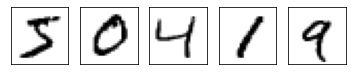

In [7]:
plot_from_sample(X[0:5])

## Conjunto y

In [8]:
y_read

,0
0,5
1,0
2,4
3,1
4,9
...,...
69995,2
69996,3
69997,4
69998,5


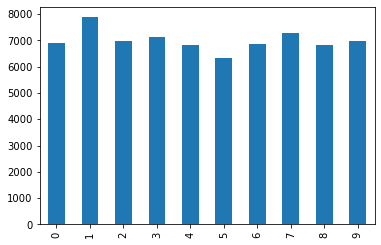

In [9]:
plt.figure()
y_read[0].value_counts().sort_index().plot.bar()
plt.show()

> Aparentemente as classes estão suficientemente balanceadas.

<div class="alert-info">O objectivo é usar as <i>imagens</i> como entrada na rede neuronal e prever o dígito mais provável.</div>

# Construção do modelo

![Classification](img/classification.png)

## Divisão dos dados em conjunto de treino e de teste

> Vamos usar 70 % dos dados para treino e 30 % para teste.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

>> Esta função já trata disso por nós e já faz _shuffle_ aos arrays.

## Mapear os valores X para o intervalo entre 0.01 e 1

In [11]:
def preprocessing(data):
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    scaler.fit(data)
    data = scaler.transform(data)
    return data

In [12]:
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)

### Razão

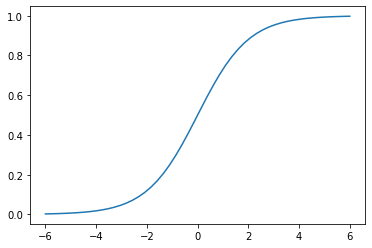

In [13]:
plt.figure()
x = np.linspace(-6, 6, num=50)
y = 1/(1 + np.exp(-x))
plt.plot(x, y)
plt.show()

Como é possível reparar, quando maior for $x$ menor será o gradiente. 

Quando menor o gradiente, menor é a capacidade de a rede aprender -- a rede fica saturada.

Neste caso, não precisamos de fazer qualquer ajuste ao conjunto de saída, pois o _output_ é uma probabilidade.

## Criar o modelo

In [14]:
clf = MLPClassifier(solver='sgd', learning_rate='constant', learning_rate_init=0.3, hidden_layer_sizes=(100), activation='logistic', max_iter=300)

## Treinar o modelo

In [15]:
clf.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=100,
              learning_rate_init=0.3, max_iter=300, solver='sgd')

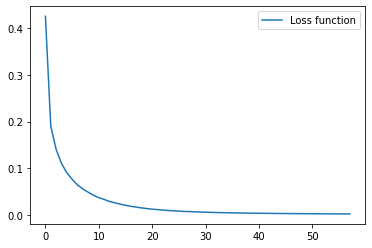

In [16]:
plt.figure()
y = clf.loss_curve_
plt.plot(y, label='Loss function')
plt.legend()
plt.show()

## Avaliar o modelo

In [17]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

### Matriz de confusão

In [18]:
cm_train = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
cm_test  = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)  

In [19]:
cm_train

array([[4842,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 5536,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 4975,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 4965,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 4746,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 4427,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 4850,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5104,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4757,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 4798]],
      dtype=int64)

In [20]:
cm_test

array([[2031,    1,    1,    1,    1,    3,   12,    1,    7,    3],
       [   1, 2310,    5,    4,    2,    2,    2,    6,    7,    2],
       [   6,    8, 1959,    5,    4,    2,    6,   15,    9,    1],
       [   3,    1,   13, 2101,    3,   21,    3,    8,   17,    6],
       [   2,    3,    4,    0, 2032,    1,   10,    4,    1,   21],
       [   1,    0,    2,   15,    3, 1834,   14,    1,    9,    7],
       [  12,    0,    1,    0,    2,    4, 2003,    0,    4,    0],
       [   0,    4,   11,    0,    7,    0,    0, 2157,    0,   10],
       [   5,    6,    7,   14,    4,   12,   10,    2, 2004,    4],
       [   5,    0,    1,   10,   22,   10,    0,   16,    4, 2092]],
      dtype=int64)

In [21]:
no_corrects = np.sum(np.diagonal(cm_test))
no_total = np.sum(cm_test)

accuracy = no_corrects/no_total
accuracy * 100

97.72857142857143

## Testar o modelo

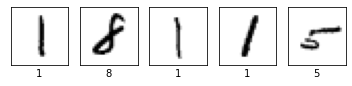

In [22]:
visual_test_size = 5
test_range = random.randint(low=0, high=len(X_test)-1, size=visual_test_size)
plot_from_sample(X_test[test_range], labels=y_pred_test[test_range])

> Contudo, é preciso notar que a rede tem *10* _outputs_ 

In [23]:
i_test = 50

prob_0 = clf.predict_proba(X_test)[i_test]
prob_0_view = pd.DataFrame(prob_0)
prob_0_view.style.apply(highlight_max, color='darkorange')

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,1.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


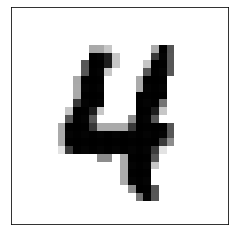

In [24]:
plot_from_sample([X_test[i_test]])

## Vamos ver os casos de erro

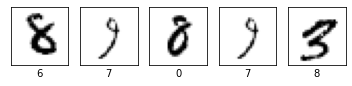

In [25]:
mask_error = y_pred_test != y_test

X_test_error = X_test[mask_error]
y_pred_error = y_pred_test[mask_error]

test_range_erro = random.randint(low=0, high=len(X_test_error)-1, size=visual_test_size)

plot_from_sample(X_test_error[test_range_erro], labels=y_pred_error[test_range_erro])